#### This script is modified base on https://github.com/tensorflow/models/blob/master/object_detection/object_detection_tutorial.ipynb

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
print(tf.__version__)

1.3.0


In [3]:
# This is needed to display the images.
%matplotlib inline
print(sys.path)
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

['', '/Users/kyleguan/Documents/SimPy', '/Users/kyleguan/Documents/CarND_term3/traffic_light_detection', '//anaconda/lib/python35.zip', '//anaconda/lib/python3.5', '//anaconda/lib/python3.5/plat-darwin', '//anaconda/lib/python3.5/lib-dynload', '//anaconda/lib/python3.5/site-packages', '//anaconda/lib/python3.5/site-packages/Sphinx-1.4.6-py3.5.egg', '//anaconda/lib/python3.5/site-packages/aeosa', '//anaconda/lib/python3.5/site-packages/Box2D-2.3.2-py3.5-macosx-10.6-x86_64.egg', '//anaconda/lib/python3.5/site-packages/keras_rcnn-0.0.1-py3.5.egg', '/Users/kyleguan/src/tqdm', '//anaconda/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg', '//anaconda/lib/python3.5/site-packages/IPython/extensions', '/Users/kyleguan/.ipython']


## Env setup
#### Note: need to identify the path of Python and Tensorflow. 
For my case, the path is '/anaconda/lib/python3.5/site-packages/tensorflow/Models'. The official instruction is provided in 
https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md. It a bit confusing. Here is my approach:
1) Make all the dependencies metioned in the above instrucation are properly installed. 
2) Create /Models subdirectory in /tensorflow, if it does not exist. 
3) Clone or download (then unzip) https://github.com/tensorflow/models in the /Models directory
4) From tensorflow/models/, execute the following to compile the protobuf libraries.
protoc object_detection/protos/*.proto --python_out=.



## Object detection imports
Here are the imports from the object detection module.

In [4]:
# The tensorflow model directory needs to changed accordingly
os.chdir('/anaconda/lib/python3.5/site-packages/tensorflow/Models')
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.
### Note: here I choose ssd_inception_v2_coco_11_06_2017 pretrained model

In [5]:
# What model to download.
#MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_NAME = 'ssd_inception_v2_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/anaconda/lib/python3.5/site-packages/tensorflow/models/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 14

In [6]:
PATH_TO_CKPT

'ssd_inception_v2_coco_11_06_2017/frozen_inference_graph.pb'

## Download Model

In [ ]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'}}

#### Note: this is hard-coded 'category_index' in the case that the above metioned label loading does not work

In [9]:
category_index={1: {'id': 1, 'name': u'person'},
 2: {'id': 2, 'name': u'bicycle'},
 3: {'id': 3, 'name': u'car'},
 4: {'id': 4, 'name': u'motorcycle'},
 5: {'id': 5, 'name': u'airplane'},
 6: {'id': 6, 'name': u'bus'},
 7: {'id': 7, 'name': u'train'},
 8: {'id': 8, 'name': u'truck'},
 9: {'id': 9, 'name': u'boat'},
 10: {'id': 10, 'name': u'traffic light'},
 11: {'id': 11, 'name': u'fire hydrant'},
 13: {'id': 13, 'name': u'stop sign'},
 14: {'id': 14, 'name': u'parking meter'}}

# Detection

In [10]:
from glob import glob
# The path to test images
PATH_TO_TEST_IMAGES_DIR = '/Users/kyleguan/Documents/CarND_term3/traffic_light_detection/traffic_light_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'traffic_light_001.jpg')]
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'left0022.jpg')]
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
IMAGE_SIZE = (9, 6)# Size, in inches, of the output images.


### Helper code 

In [11]:
#Convert image to Numpy array
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [12]:
# Convert the normalized coordinate of bounding boxes to pixel values
def box_normal_to_pixel(box, dim):
    
    height, width = dim[0], dim[1]
    box_pixel = [int(box[0]*height), int(box[1]*width), int(box[2]*height), int(box[3]*width)]
    return np.array(box_pixel)    

In [13]:
# Crop the images defined by a bounding box
import cv2
def crop_img(boxes, classes, scores, image_np, plot=True):
    boxes=np.squeeze(boxes)
    classes =np.squeeze(classes)
    scores = np.squeeze(scores)
    #print classes
    #print scores
    cls = classes.tolist()
    idx = next(i for i, v in enumerate(cls) if v == 10.)
    #print(idx)
    dim = image_np.shape[0:2]
    b = box_normal_to_pixel(boxes[idx], dim)
    print('Normalized box coordinates: ', b)
    print('Score of the box: ', scores[idx])
    img_resize = cv2.resize(image_np_copy[b[0]:b[2], b[1]:b[3]], (32, 32)) 
    if plot:
        plt.figure(figsize=(3,3))
        plt.imshow(img_resize)
        plt.show()
    return img_resize    

### Import Keras and load the classification model
#### Note:  Keras model directory needs to be changed accordingly.

In [14]:
import keras
from keras.models import load_model
save_dir = os.path.join('/Users/kyleguan/Documents/CarND_term3/traffic_light_detection/', 'saved_models')
model_name = 'tl_model_1.h5'
model_path = os.path.join(save_dir, model_name)
print(model_path)
model1 = load_model(model_path)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
/Users/kyleguan/Documents/CarND_term3/traffic_light_detection/saved_models/tl_model_1.h5


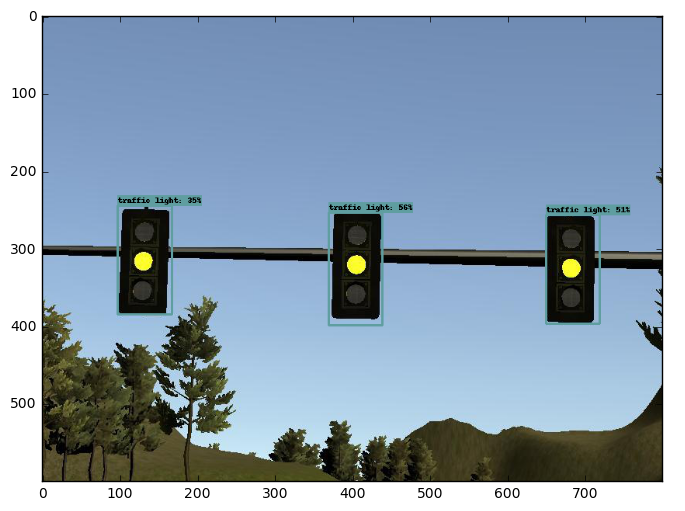

Localization time in sec:  2.0660550594329834
Normalized box coordinates:  [254 369 399 438]
Score of the box:  0.561715


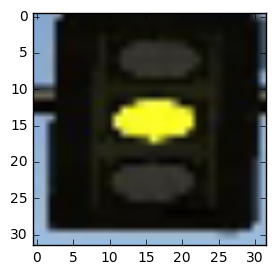

Classification time in sec:  0.0195620059967041
yellow , confidence:  [[  1.73104554e-02   1.97901740e-04   9.82491672e-01]]


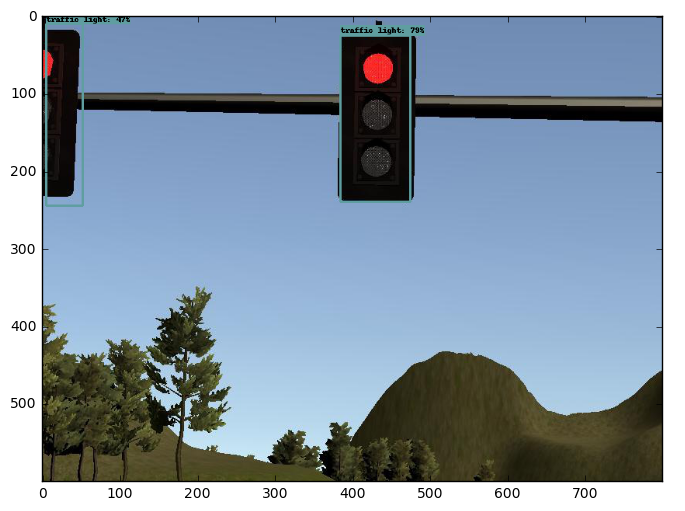

Localization time in sec:  2.041486978530884
Normalized box coordinates:  [ 26 384 240 474]
Score of the box:  0.790404


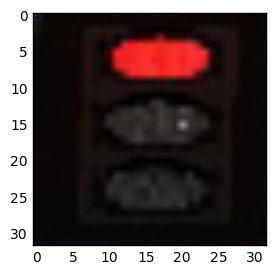

Classification time in sec:  0.002135038375854492
red , confidence:  [[  1.00000000e+00   1.30611264e-08   5.11292093e-08]]


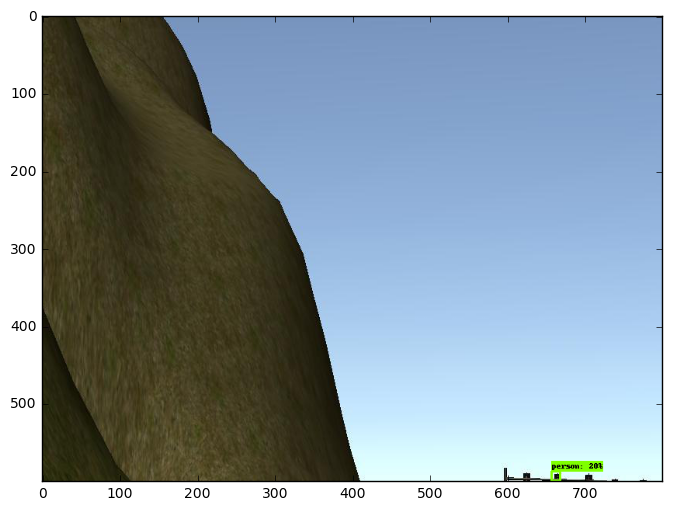

Localization time in sec:  2.498297929763794
Normalized box coordinates:  [583 592 597 601]
Score of the box:  0.00919213


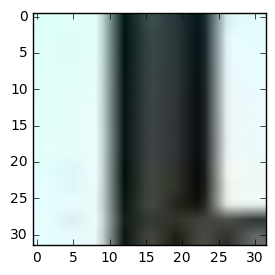

Classification time in sec:  0.0022449493408203125
green , confidence:  [[  1.16251162e-04   9.99775589e-01   1.08159453e-04]]


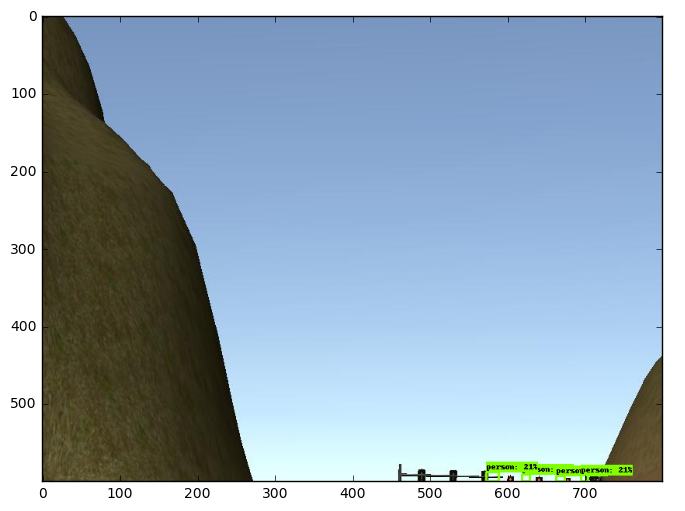

Localization time in sec:  2.6327340602874756
Normalized box coordinates:  [584 480 600 496]
Score of the box:  0.102796


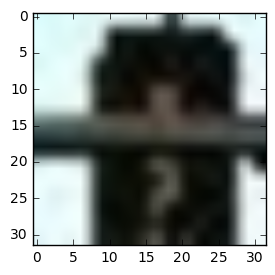

Classification time in sec:  0.002103090286254883
yellow , confidence:  [[ 0.00801362  0.36262554  0.62936085]]


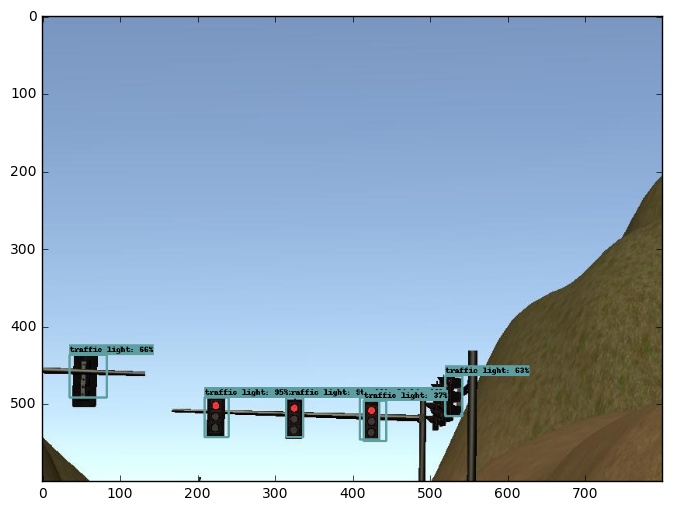

Localization time in sec:  3.008241891860962
Normalized box coordinates:  [492 314 543 336]
Score of the box:  0.98298


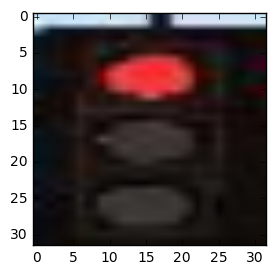

Classification time in sec:  0.0022399425506591797
red , confidence:  [[  9.99999762e-01   6.74888323e-09   2.44353089e-07]]


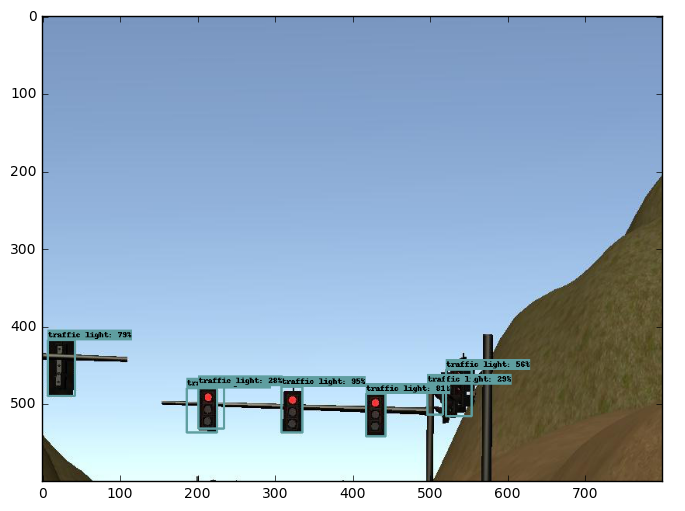

Localization time in sec:  2.959123134613037
Normalized box coordinates:  [478 308 537 335]
Score of the box:  0.950622


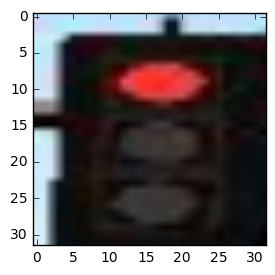

Classification time in sec:  0.002171039581298828
red , confidence:  [[  9.99999762e-01   3.31929928e-09   2.44631963e-07]]


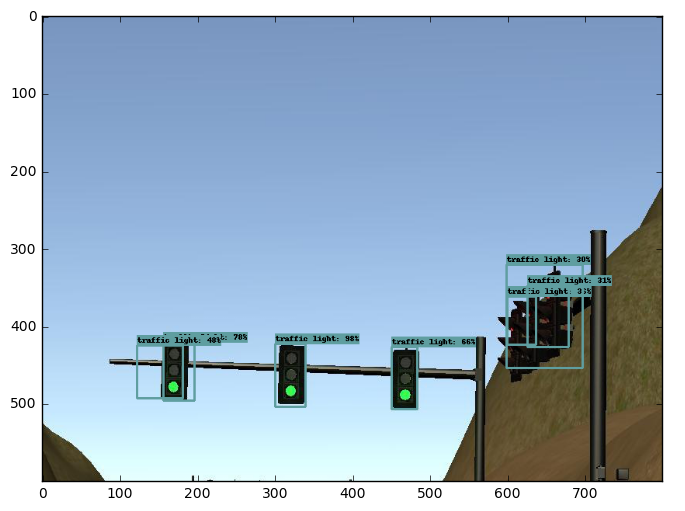

Localization time in sec:  2.7266740798950195
Normalized box coordinates:  [423 300 504 339]
Score of the box:  0.987391


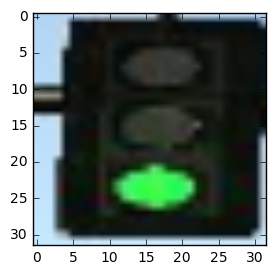

Classification time in sec:  0.002109050750732422
green , confidence:  [[ 0.01002735  0.98338842  0.00658423]]


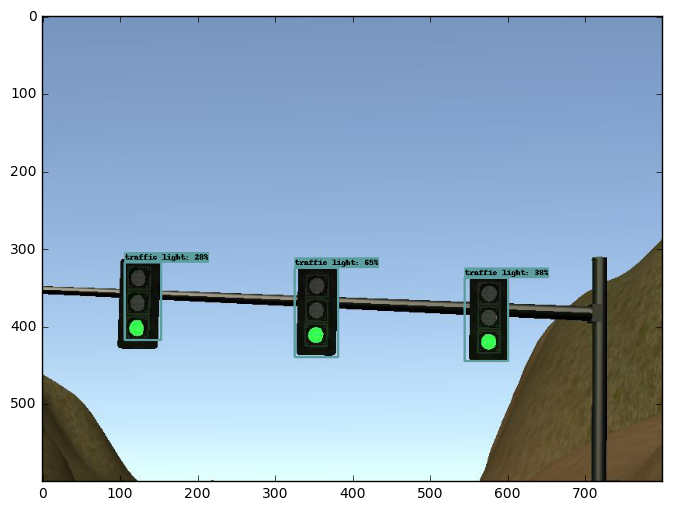

Localization time in sec:  2.9578680992126465
Normalized box coordinates:  [325 325 440 381]
Score of the box:  0.651711


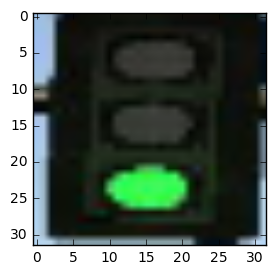

Classification time in sec:  0.003203153610229492
green , confidence:  [[ 0.00276755  0.99595672  0.00127574]]


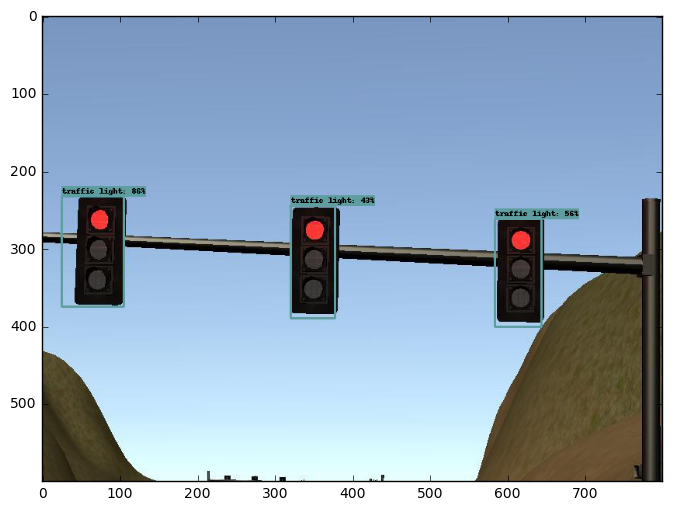

Localization time in sec:  2.36047101020813
Normalized box coordinates:  [233  25 375 105]
Score of the box:  0.868163


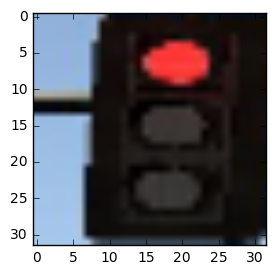

Classification time in sec:  0.0019311904907226562
red , confidence:  [[  9.99999881e-01   2.67502518e-08   1.40032910e-07]]


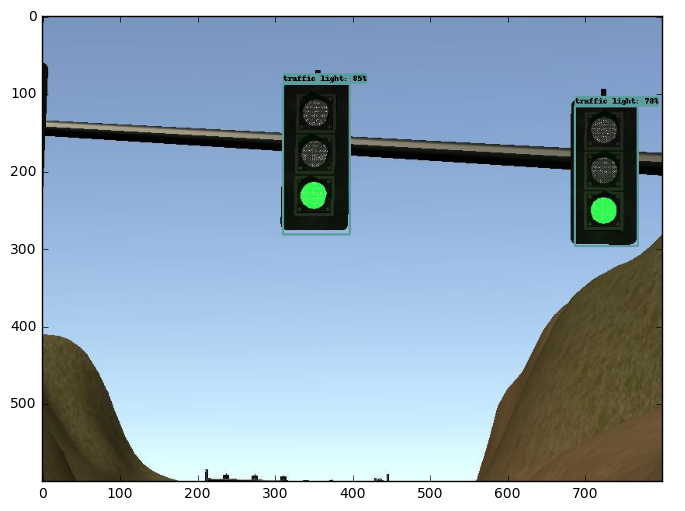

Localization time in sec:  2.3599419593811035
Normalized box coordinates:  [ 88 310 282 396]
Score of the box:  0.856761


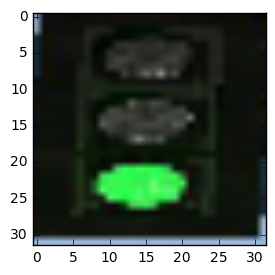

Classification time in sec:  0.0018451213836669922
green , confidence:  [[ 0.00176888  0.99619389  0.00203727]]


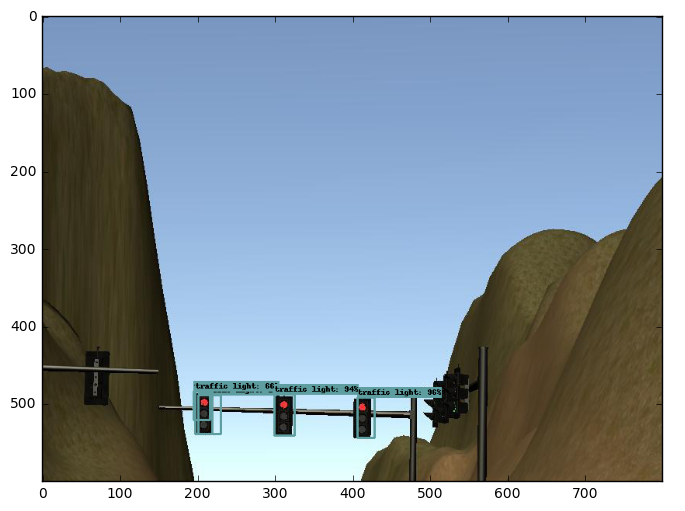

Localization time in sec:  2.3770549297332764
Normalized box coordinates:  [492 406 544 428]
Score of the box:  0.96848


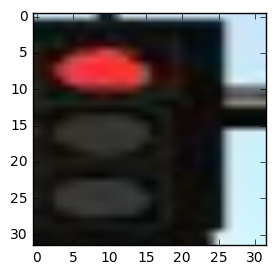

Classification time in sec:  0.0017800331115722656
red , confidence:  [[  9.96974349e-01   2.84734950e-03   1.78215807e-04]]


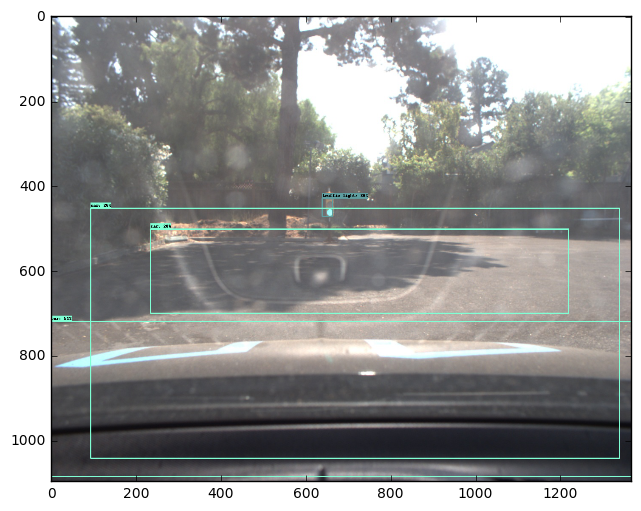

Localization time in sec:  2.0640480518341064
Normalized box coordinates:  [431 638 473 662]
Score of the box:  0.368542


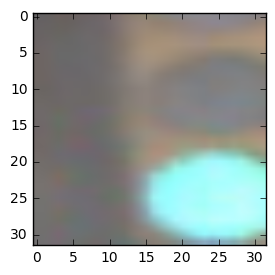

Classification time in sec:  0.0017790794372558594
green , confidence:  [[ 0.01543621  0.9788053   0.00575855]]


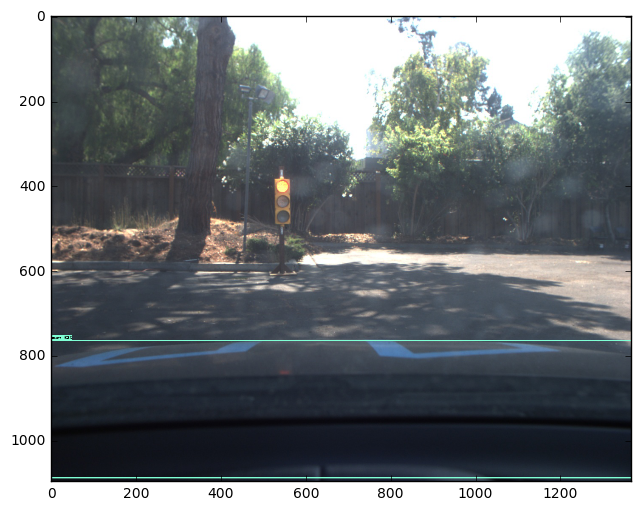

Localization time in sec:  2.09055495262146
Normalized box coordinates:  [374 516 508 571]
Score of the box:  0.0633607


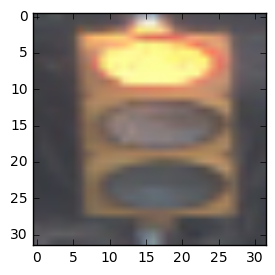

Classification time in sec:  0.002079010009765625
red , confidence:  [[  1.00000000e+00   1.72179049e-09   2.55574246e-08]]


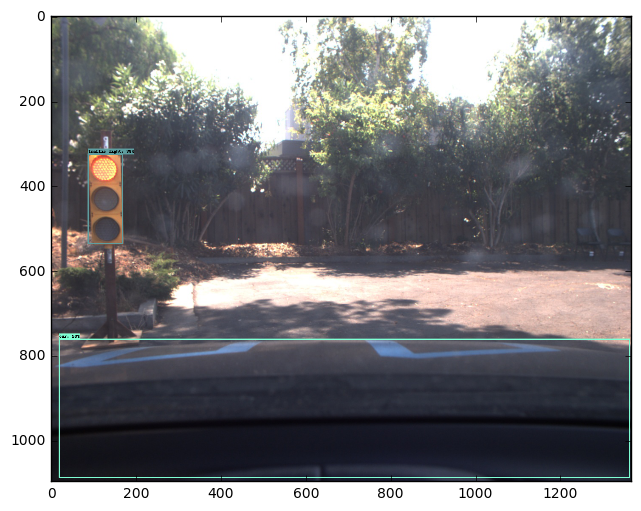

Localization time in sec:  2.344926118850708
Normalized box coordinates:  [327  87 537 168]
Score of the box:  0.380138


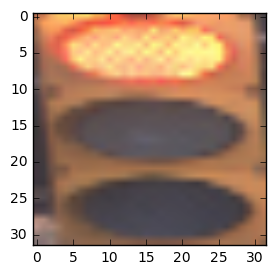

Classification time in sec:  0.0020890235900878906
red , confidence:  [[  1.00000000e+00   1.12865661e-09   2.01490435e-10]]


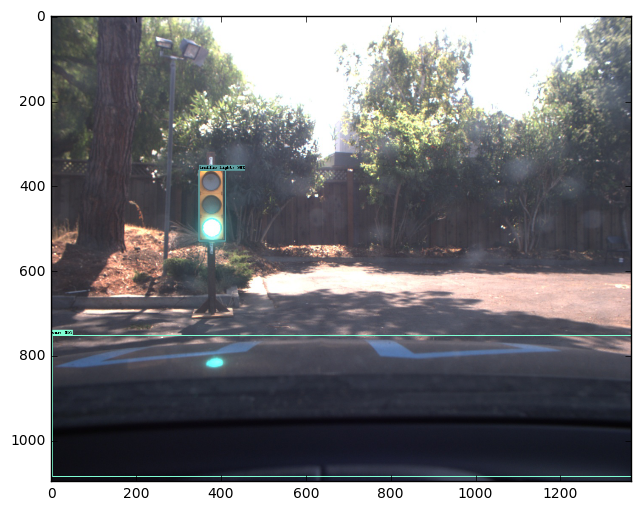

Localization time in sec:  2.715507984161377
Normalized box coordinates:  [365 348 531 410]
Score of the box:  0.901435


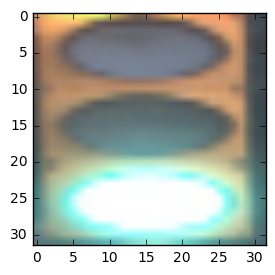

Classification time in sec:  0.0022830963134765625
green , confidence:  [[  2.40762602e-05   9.99975920e-01   2.87361566e-08]]


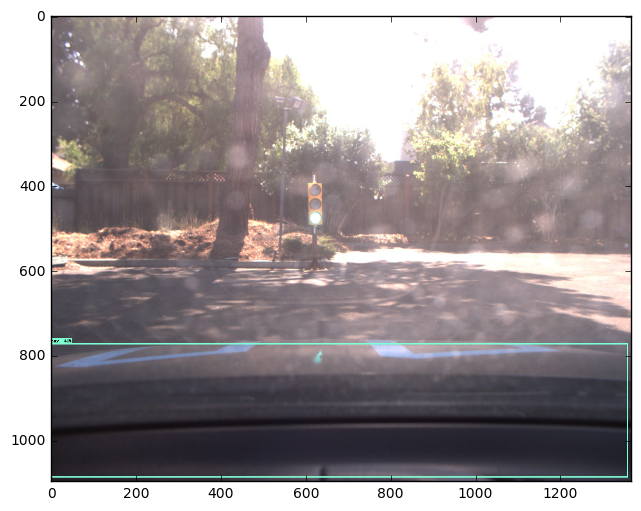

Localization time in sec:  2.640568971633911
Normalized box coordinates:  [388 601 483 640]
Score of the box:  0.131241


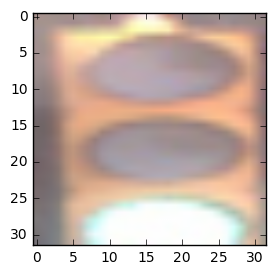

Classification time in sec:  0.0019769668579101562
green , confidence:  [[ 0.08474707  0.91246754  0.00278535]]


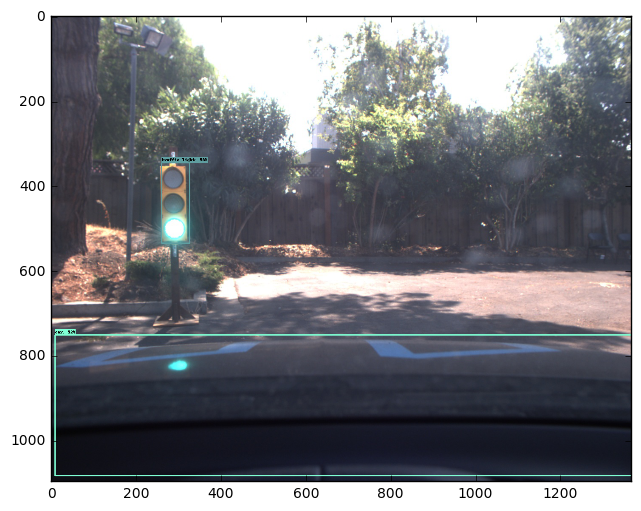

Localization time in sec:  3.014039993286133
Normalized box coordinates:  [347 260 536 326]
Score of the box:  0.58511


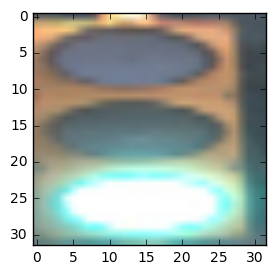

Classification time in sec:  0.001934051513671875
green , confidence:  [[  5.64275433e-06   9.99994397e-01   2.90352471e-08]]


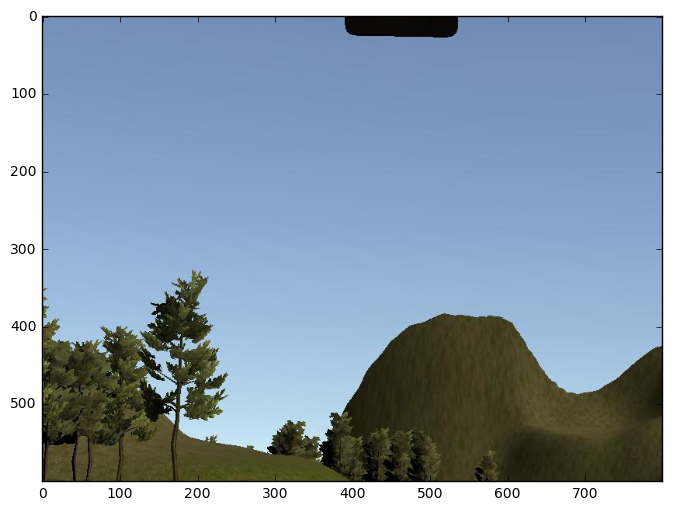

Localization time in sec:  2.729053020477295
Normalized box coordinates:  [  0 389  32 537]
Score of the box:  0.0826386


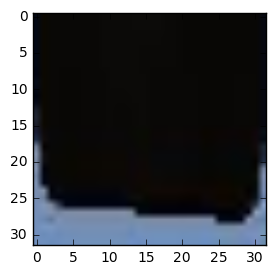

Classification time in sec:  0.0019381046295166016
green , confidence:  [[ 0.14680211  0.72322768  0.12997019]]


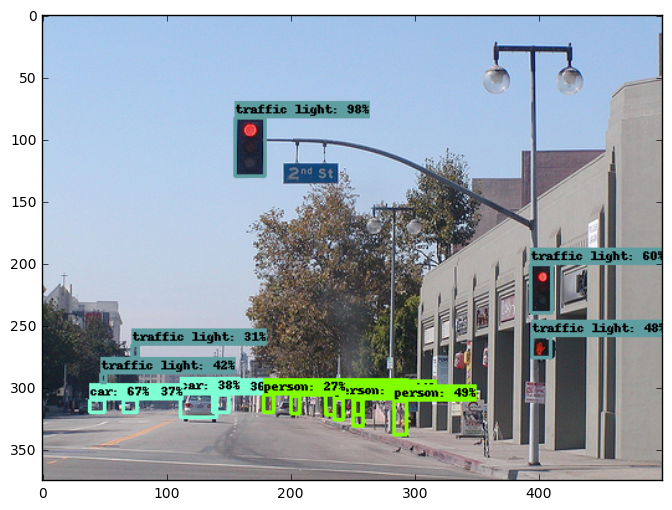

Localization time in sec:  2.669955015182495
Normalized box coordinates:  [ 83 155 130 179]
Score of the box:  0.987533


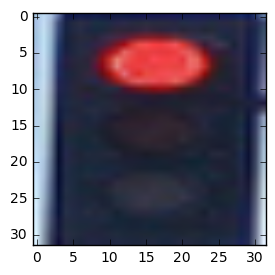

Classification time in sec:  0.0019371509552001953
red , confidence:  [[  1.00000000e+00   6.15541021e-11   1.23697400e-10]]


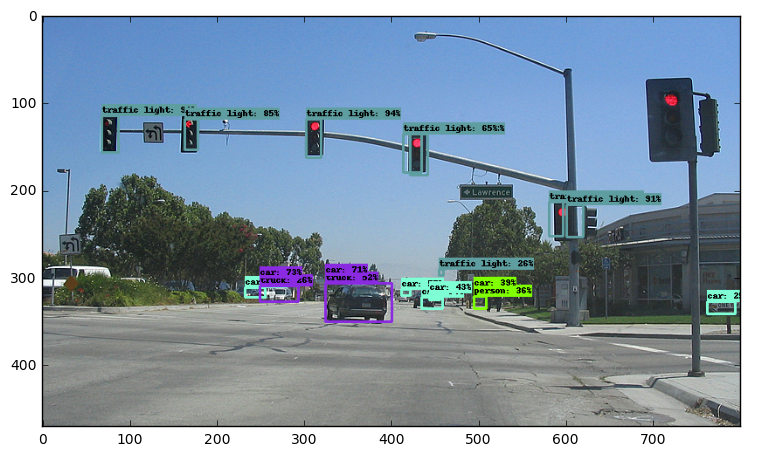

Localization time in sec:  3.0744237899780273
Normalized box coordinates:  [119 302 163 319]
Score of the box:  0.948295


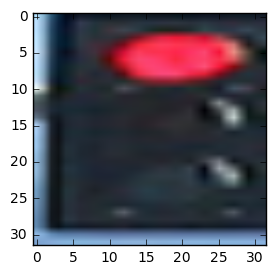

Classification time in sec:  0.0019431114196777344
red , confidence:  [[  1.00000000e+00   3.51210894e-10   2.08203871e-10]]


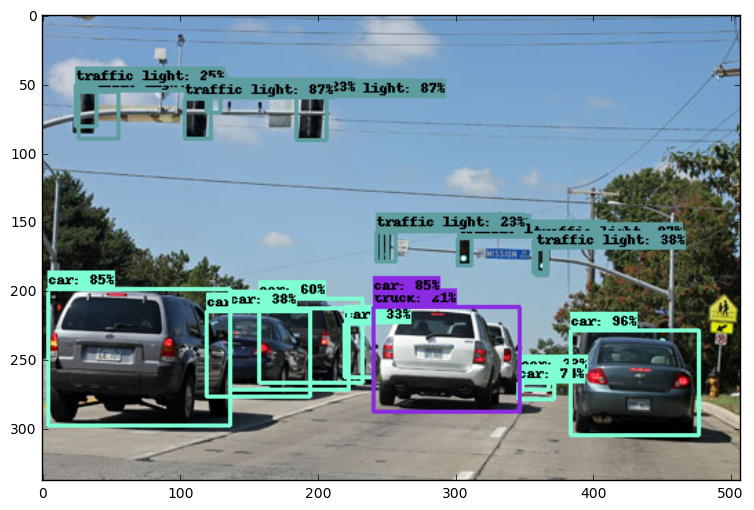

Localization time in sec:  2.580626964569092
Normalized box coordinates:  [162 301 182 311]
Score of the box:  0.985654


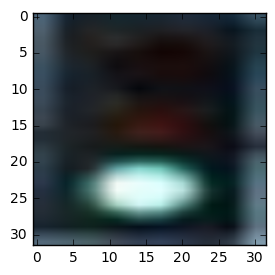

Classification time in sec:  0.0019099712371826172
green , confidence:  [[  4.94104324e-06   9.99986172e-01   8.94744880e-06]]


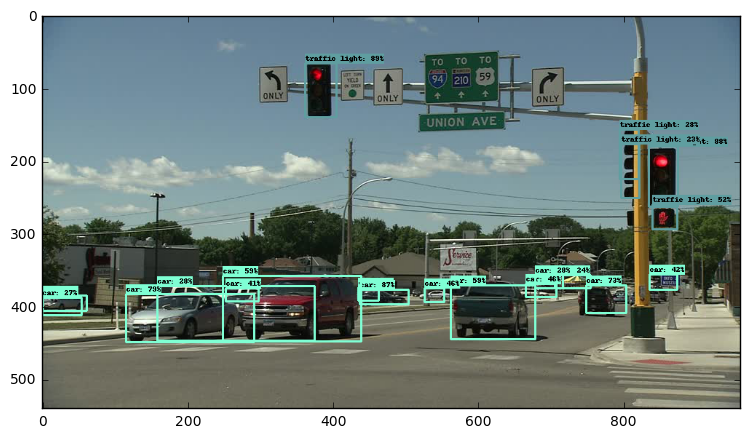

Localization time in sec:  3.1009440422058105
Normalized box coordinates:  [ 66 361 140 404]
Score of the box:  0.897219


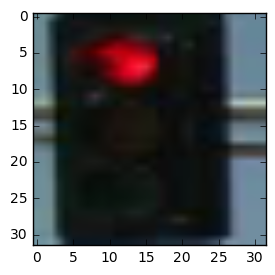

Classification time in sec:  0.0019669532775878906
red , confidence:  [[  9.99945521e-01   1.66568734e-05   3.77710821e-05]]


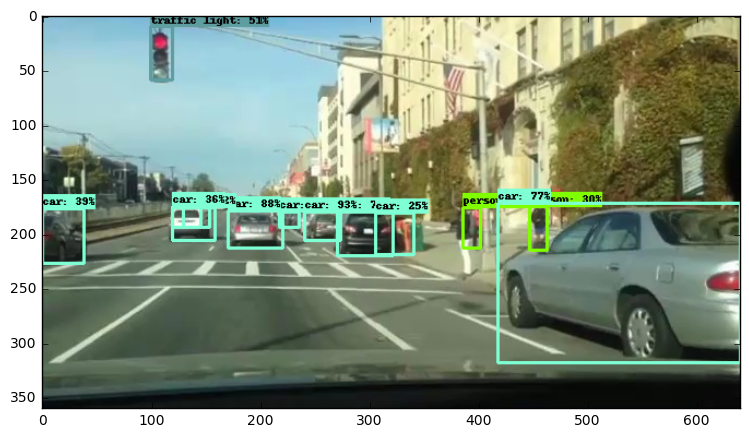

Localization time in sec:  2.7334039211273193
Normalized box coordinates:  [ 10  99  59 119]
Score of the box:  0.518782


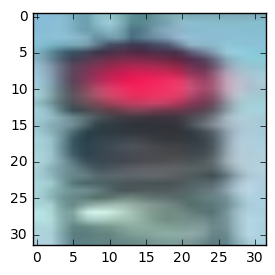

Classification time in sec:  0.001954793930053711
red , confidence:  [[  1.00000000e+00   1.86140916e-08   4.60129748e-08]]


In [15]:
color=['red', 'green', 'yellow']
import time

for image_path in TEST_IMAGE_PATHS:
    with detection_graph.as_default():
    #for image_path in TEST_IMAGE_PATHS:
        with tf.Session(graph=detection_graph) as sess:
              image = Image.open(image_path)
              # the array based representation of the image will be used later in order to prepare the
              # result image with boxes and labels on it.
              image_np = load_image_into_numpy_array(image)
              image_np_copy = np.copy(image_np)  
              # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
              image_np_expanded = np.expand_dims(image_np, axis=0)
              image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
              # Each box represents a part of the image where a particular object was detected.
              boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
              # Each score represent how level of confidence for each of the objects.
              # Score is shown on the result image, together with the class label.
              scores = detection_graph.get_tensor_by_name('detection_scores:0')
              classes = detection_graph.get_tensor_by_name('detection_classes:0')
              num_detections = detection_graph.get_tensor_by_name('num_detections:0')
              # Actual detection.
              time_start = time.time()  
              (boxes, scores, classes, num_detections) = sess.run(
                  [boxes, scores, classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})
              # Visualization of the results of a detection.
              time_end = time.time()
              vis_util.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  np.squeeze(boxes),
                  np.squeeze(classes).astype(np.int32),
                  np.squeeze(scores),
                  category_index,
                  use_normalized_coordinates=True,min_score_thresh=.2,
                  line_thickness=3)

              plt.figure(figsize=IMAGE_SIZE)
              plt.imshow(image_np)
              plt.show()  
              print ('Localization time in sec: ', time_end-time_start)
              img_resize = crop_img(boxes, classes, scores, image_np_copy, plot=True) 
             
    time_start = time.time()
    img_resize=cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB) 
    img_resize1 = np.expand_dims(img_resize, axis=0).astype('float32')
    img_resize1/=255.
    predict = model1.predict(img_resize1)
    time_end = time.time()
    print ('Classification time in sec: ', time_end-time_start)
    print(color[np.argmax(predict)], ', confidence: ', predict)
      
      #file_name='/Users/kyleguan/Documents/CarND_term3/traffic_light_detection/resize/frame{:03d}.jpg'.format(i)   
      #img_resize=cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB)  
      #cv2.imwrite(file_name,img_resize)
      #img_resize = np.expand_dims(img_resize, axis=0).astype('float32')
      #img_resize/=255.
      #pred = model1.predict(img_resize)  
      #i+=1